In [17]:
import numpy as np
import pandas as pd
import xgboost
import sklearn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score

In [12]:
# step1：去掉数据不完整的行
df = pd.read_csv("2017.csv").dropna()
# step2：性别、是否吸烟等特征转one-hot
df = pd.get_dummies(df, columns=['sex','SMK_STAT_TYPE_RSPS_CD'])
# step3: 去掉creatinine高于2.5的样本
df = df.loc[(df["CREATININE "]<=2.5)&(df["CREATININE "]>=0.0)]
# step4: 切分训练集与测试集
df_train = df[0:900000]; df_test = df[900000:990112] 

In [13]:
# step5: 训练集与测试集下采样
intervals = [(i * 0.1 + 0.05, i * 0.1 + 0.15) for i in range(25)]

temp_train, temp_test = [], []

for index, (low, high) in enumerate(intervals):
    
    df_sample_train = df_train.loc[(df_train["CREATININE "] > low) & (df_train["CREATININE "] < high)]
    df_sample_test  = df_test.loc[(df_test["CREATININE "] > low) & (df_test["CREATININE "] < high)]
    
    if index in range(3, 14): df_sample_train = df_sample_train.sample(2500)
    if index in range(3, 16): df_sample_test  = df_sample_test.sample(100)
    
    temp_train.append(df_sample_train)
    temp_test.append(df_sample_test)

df_train = pd.concat(temp_train, ignore_index=True)
df_test = pd.concat(temp_test, ignore_index=True)
df_train = shuffle(df_train)

# step6: 选取特征x与目标y
y_train = df_train["CREATININE "].values.reshape(-1, 1)
y_train_stage = df_train["stage"].values
x_train = df_train.drop(columns=["id", "sido", "CREATININE ", "GFR", "stage", "height", "weight"]).values

y_test = df_test["CREATININE "].values.reshape(-1, 1)
y_test_stage = df_test["stage"].values
x_test = df_test.drop(columns=["id", "sido", "CREATININE ", "GFR", "stage", "height", "weight"]).values

In [14]:
# step7: 使用自定义loss_func与自定义eval_metric训练模型，，计算预测值与真实值的R2
mean_value = df["CREATININE "].mean()

weights = [1] * 10

intervals = [0.1 * i * (df['CREATININE '].max() - df['CREATININE '].min()) + df['CREATININE '].min() for i in range(0, 11)]
intervals[10] += 0.001

def custom_loss(true,pred):

    error = pred - true
    
    global weights, intervals
    
    for i in range(len(true)):
        
        for j in range(0, len(intervals)-1):
            
            if intervals[j] <= true[i] < intervals[j+1]:
                error[i] = error[i] * (weights[j] / np.mean(weights))
                break
                
    grad = error
    
    return grad, np.ones_like(pred)

def custom_eval(true, pred):

    error_sum, sample_count = [0] * 10, [0] * 10
    
    global weights, intervals
    
    for i in range(len(true)):
        
        error_abs = abs(true[i] - pred[i])
        
        for j in range(0, len(intervals)-1):
            
            if intervals[j] <= true[i] < intervals[j+1]:
                error_sum[j] += error_abs
                sample_count[j] += 1
                break

    weights = [error_sum[j] / sample_count[j] if sample_count[j] > 0 else 0 for j in range(10)]

    print([float(weight) for weight in weights])
  
    return np.mean(abs(pred-true))

model = xgboost.XGBRegressor(
            max_depth=10, n_estimators=500, learning_rate=0.05, base_score = mean_value,
            min_child_weight=100, nthread=4, subsample=1, early_stopping_rounds=10, 
            colsample_bytree=1, reg_alpha=0, reg_lambda=0, gamma=0,
            eval_metric=custom_eval, objective=custom_loss,seed=10
        )

model.fit(
    x_train, y_train, verbose=1, 
    eval_set=[(x_train, y_train),(x_test, y_test)],  
    
)

print("R2指数：",model.score(x_test, y_test))
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

[0.6371434926986694, 0.3930298686027527, 0.14842520654201508, 0.08854847401380539, 0.3327932357788086, 0.5743075013160706, 0.7594885230064392, 0.9915453195571899, 1.263862133026123, 1.5074743032455444]
[0.6304138898849487, 0.3929910361766815, 0.14852401614189148, 0.0881115049123764, 0.331985741853714, 0.5766066908836365, 0.7624902725219727, 1.0012587308883667, 1.252981185913086, 1.480426549911499]
[0]	validation_0-rmse:0.45572	validation_0-custom_eval:0.36834	validation_1-rmse:0.53871	validation_1-custom_eval:0.43666
[0.6390639543533325, 0.3895813226699829, 0.14825105667114258, 0.08175226300954819, 0.3211129605770111, 0.5543255805969238, 0.7306179404258728, 0.9551017880439758, 1.220795750617981, 1.460160732269287]
[0.6325699687004089, 0.38910239934921265, 0.1483466774225235, 0.08099669218063354, 0.3194958567619324, 0.5560739040374756, 0.7306208610534668, 0.9683216214179993, 1.2045295238494873, 1.4311593770980835]
[1]	validation_0-rmse:0.44279	validation_0-custom_eval:0.35813	validation

In [15]:
# step8: 将预测的creatinine与其他特征拼接，进行CKD的二分类预测
y_train_stage = np.where(y_train_stage <= 2, 0, 1).reshape(34220, 1)
x_train = np.hstack((x_train, np.array(train_pred).reshape(34220,1)))

y_test_stage = np.where(y_test_stage <= 2, 0, 1).reshape(1592, 1)
x_test = np.hstack((x_test, np.array(test_pred).reshape(1592,1)))

model_c = xgboost.XGBClassifier(
            max_depth=8, n_estimators=100, learning_rate=0.05, min_child_weight=100, 
            nthread=8, subsample=0.8,  colsample_bytree=0.8, objective='binary:logistic',
            reg_alpha=0, reg_lambda=0, gamma=0, seed=10,
            eval_metric="logloss", early_stopping_rounds=10
)

model_c.fit(
    x_train, y_train_stage, verbose=1, 
    eval_set=[(x_train, y_train_stage), (x_test, y_test_stage)], 
)

[0]	validation_0-logloss:0.57340	validation_1-logloss:0.63470
[1]	validation_0-logloss:0.55853	validation_1-logloss:0.61628
[2]	validation_0-logloss:0.54174	validation_1-logloss:0.59634
[3]	validation_0-logloss:0.52662	validation_1-logloss:0.57864
[4]	validation_0-logloss:0.51606	validation_1-logloss:0.56613
[5]	validation_0-logloss:0.50648	validation_1-logloss:0.55478
[6]	validation_0-logloss:0.49476	validation_1-logloss:0.54127
[7]	validation_0-logloss:0.48410	validation_1-logloss:0.52902
[8]	validation_0-logloss:0.47432	validation_1-logloss:0.51797
[9]	validation_0-logloss:0.46535	validation_1-logloss:0.50769
[10]	validation_0-logloss:0.45892	validation_1-logloss:0.50005
[11]	validation_0-logloss:0.45125	validation_1-logloss:0.49182
[12]	validation_0-logloss:0.44608	validation_1-logloss:0.48606
[13]	validation_0-logloss:0.43943	validation_1-logloss:0.47875
[14]	validation_0-logloss:0.43325	validation_1-logloss:0.47191
[15]	validation_0-logloss:0.42744	validation_1-logloss:0.46557
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=100, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, nthread=8, num_parallel_tree=None, ...)

准确率： 0.8253768844221105
0.8919774594571342


<Figure size 640x480 with 0 Axes>

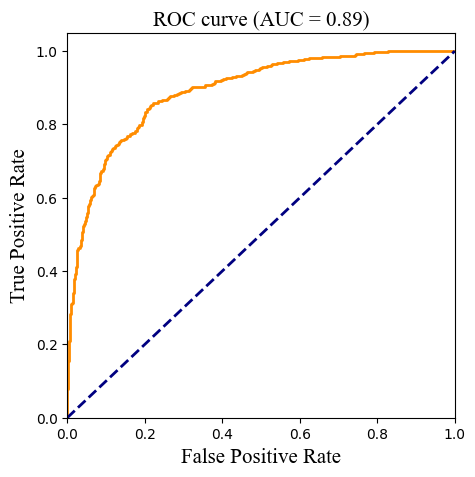

Test Accuracy: 80.84%
[[821. 204.]
 [101. 466.]]


In [52]:
# step9: 绘制ROC曲线，统计分类准确率及混淆矩阵
print("准确率：",model_c.score(x_test,y_test_stage))

test_pred = model_c.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds  =  roc_curve(y_test_stage, test_pred) 

roc_auc =auc(fpr, tpr) 
print(roc_auc)

plt.figure()
plt.figure(figsize=(5,5))
font = {'family': 'Times New Roman','weight': 'normal','size': 15}
plt.plot(fpr, tpr, color='darkorange',lw=2) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', font)
plt.ylabel('True Positive Rate', font)
plt.title('ROC curve (AUC = %0.2f)' % roc_auc, font)
plt.show()

# 调整阈值后的准确率v
test_pred = np.where(test_pred >= 0.3, 1, 0)
accuracy_hold = accuracy_score(y_test_stage, test_pred)
print("Test Accuracy: %.2f%%" % (accuracy_hold * 100.0))

# 统计混淆矩阵
confusion_matrix = np.zeros((2, 2))
confusion_matrix += np.array([[sum((y_test_stage.reshape(-1) == i) & (test_pred == j)) for j in range(2)] for i in range(2)])
print(confusion_matrix)